In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults

C:\Users\kdabhadk\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 5

In [4]:
from getdata_01 import *
rate_data = get_data()

In [5]:
rate_data.head()

,Rate
Day,
2018-01-15,63.5281
2018-01-16,64.0186
2018-01-17,63.8344
2018-01-18,63.8754
2018-01-19,63.8444


In [6]:
rate_data.tail()

,Rate
Day,
2018-07-09,68.6697
2018-07-10,68.6450
2018-07-11,68.7319
2018-07-12,68.4871
2018-07-13,68.4949


In [7]:
rate_data.describe()

,Rate
count,180.000000
mean,66.080757
std,1.641169
min,63.528100
25%,64.895950
50%,65.275550
75%,67.618600
max,68.991000


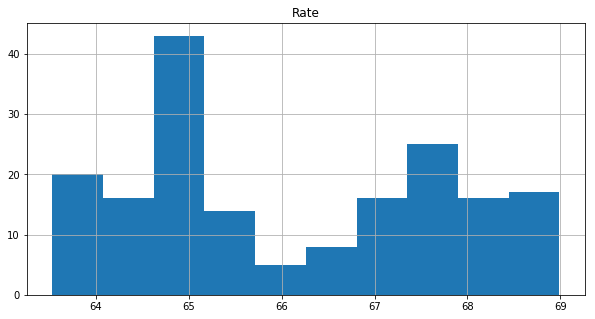

In [8]:
rate_data.hist()
plt.show()

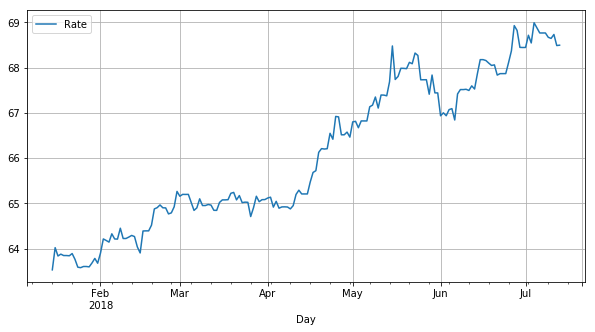

In [9]:
plt.rcParams["figure.figsize"] = fig_size
rate_data.plot()
plt.grid()

## Stationarity analysis

Determine stationarity <br>
Dickey-Fuller test for stationarity

In [10]:
df_test = adfuller(rate_data['Rate'], autolag='AIC')
result = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test[4].items():
    result['Critical Value (%s)'%key] = value
print (result)

Test Statistic                  -0.515179
p-value                          0.889020
#Lags Used                       1.000000
Number of Observations Used    178.000000
Critical Value (1%)             -3.467632
Critical Value (5%)             -2.877918
Critical Value (10%)            -2.575501
dtype: float64


### Introducing stationarity

### 1. Difference between data and moving average

Plot rolling mean (Moving Average)

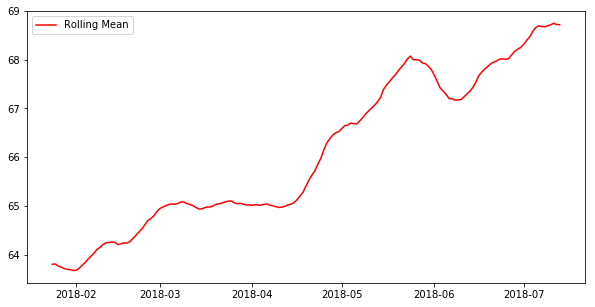

In [11]:
rolling_mean = pd.Series.rolling(rate_data['Rate'],window=10,center=False).mean()
plt.rcParams["figure.figsize"] = fig_size
#rate_data.plot()
rmean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.show()

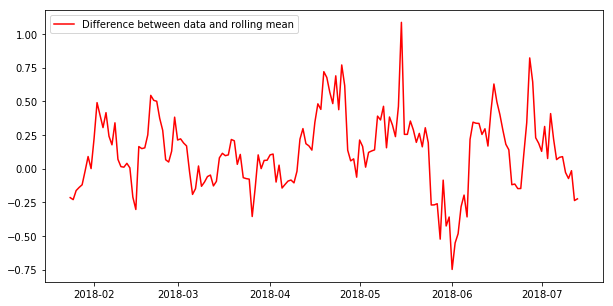

In [12]:
rolling_mean_diff=rate_data['Rate']-rolling_mean
#plt.rcParams["figure.figsize"] = fig_size
plt.plot(rolling_mean_diff, color='red',label='Difference between data and rolling mean')
plt.legend(loc='best')
plt.show()
rolling_mean_diff.dropna(inplace=True)

In [13]:
df_rmean_diff = adfuller(rolling_mean_diff, autolag='AIC')
result_rmean_diff = pd.Series(df_rmean_diff[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_rmean_diff[4].items():
    result_rmean_diff['Critical Value (%s)'%key] = value
print (result_rmean_diff)

Test Statistic                  -4.691894
p-value                          0.000087
#Lags Used                       0.000000
Number of Observations Used    170.000000
Critical Value (1%)             -3.469413
Critical Value (5%)             -2.878696
Critical Value (10%)            -2.575917
dtype: float64


In [14]:
### 2. Moving average of log(data)

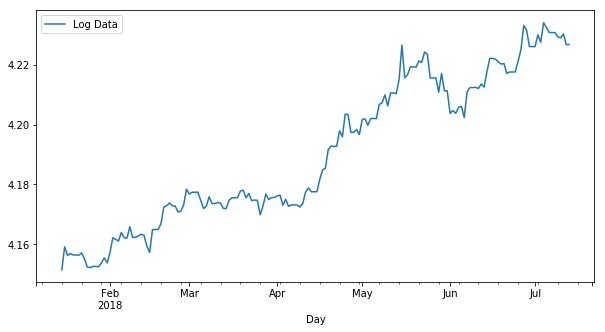

In [15]:
rate_data_log=np.log(rate_data['Rate'])
plt.rcParams["figure.figsize"] = fig_size
rate_data_log.plot(label='Log Data')
plt.legend(loc='best')
plt.show()

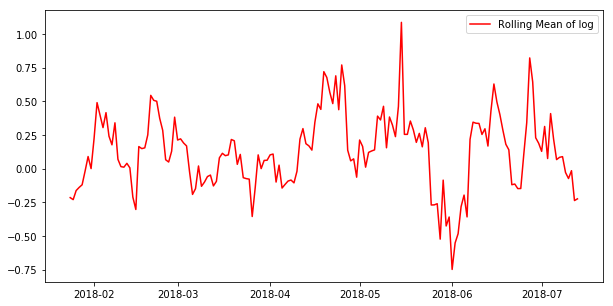

In [16]:
log_rolling_mean=pd.Series.rolling(rate_data_log,window=10,center=False).mean()
plt.rcParams["figure.figsize"] = fig_size
log_rolmean_diff=rate_data_log-log_rolling_mean
log_rmean_diff= plt.plot(rolling_mean_diff, color='red', label='Rolling Mean of log')
plt.legend(loc='best')
plt.show()
log_rolmean_diff.dropna(inplace=True)

In [17]:
df_test_log = adfuller(log_rolmean_diff, autolag='AIC')
result_log = pd.Series(df_test_log[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test_log[4].items():
    result_log['Critical Value (%s)'%key] = value
print (result_log)

Test Statistic                  -4.680477
p-value                          0.000092
#Lags Used                       0.000000
Number of Observations Used    170.000000
Critical Value (1%)             -3.469413
Critical Value (5%)             -2.878696
Critical Value (10%)            -2.575917
dtype: float64


In [18]:
### 3. Exponentially Weighted Moving Average of Log

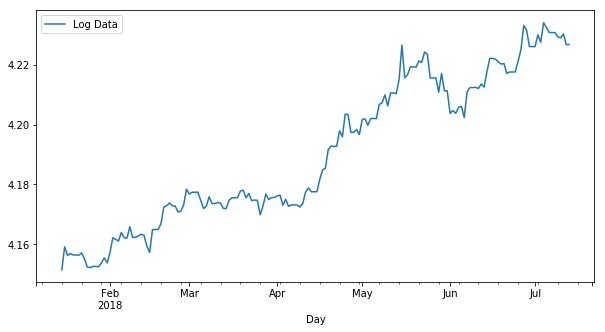

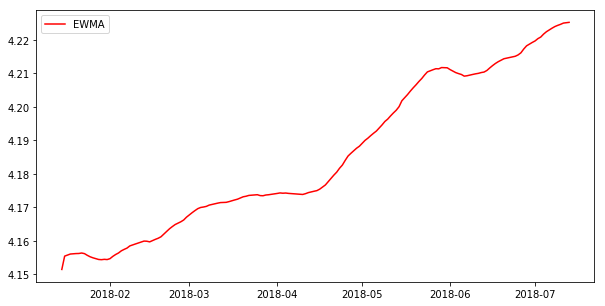

In [19]:
ewma_data=pd.Series.ewm(rate_data_log,halflife=10,min_periods=0,adjust=True,ignore_na=False).mean()
plt.rcParams["figure.figsize"] = fig_size
rate_data_log.plot(label='Log Data')
plt.legend(loc='best')
plt.show()
plt.plot(ewma_data, color='red',label='EWMA')
plt.legend()
plt.legend(loc='best')
plt.show()

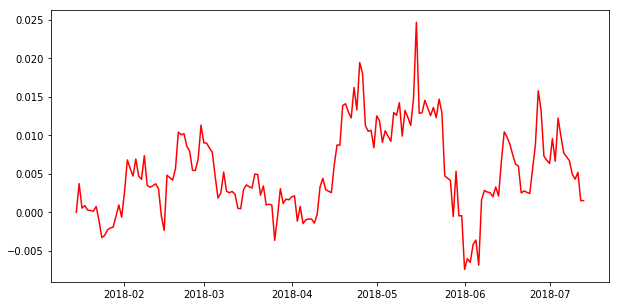

In [20]:
ewma_diff=rate_data_log-ewma_data
plt.rcParams["figure.figsize"] = fig_size
plt.plot(ewma_diff, color='red')

In [21]:
df_test_ewma = adfuller(ewma_diff, autolag='AIC')
result_ewma = pd.Series(df_test_ewma[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test_ewma[4].items():
    result_ewma['Critical Value (%s)'%key] = value
print (result_ewma)

Test Statistic                  -2.943951
p-value                          0.040471
#Lags Used                       1.000000
Number of Observations Used    178.000000
Critical Value (1%)             -3.467632
Critical Value (5%)             -2.877918
Critical Value (10%)            -2.575501
dtype: float64


In [22]:
### 4. First order differencing

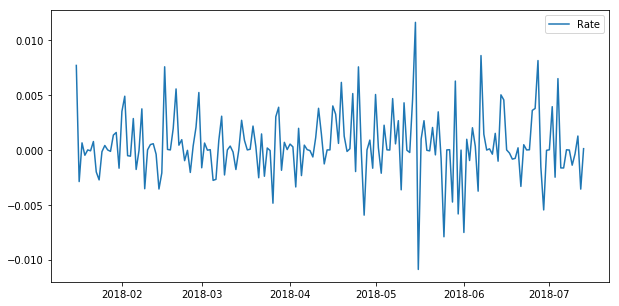

In [23]:
rate_log_diff = rate_data_log - rate_data_log.shift()
rate_log_diff.dropna(inplace=True)
plt.rcParams["figure.figsize"] = fig_size
plt.plot(rate_log_diff)
plt.legend('Log Data')
plt.legend(loc='best')
plt.show()

In [24]:
df_test_logdiff = adfuller(rate_log_diff, autolag='AIC')
result_logdiff = pd.Series(df_test_logdiff[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test_logdiff[4].items():
    result_logdiff['Critical Value (%s)'%key] = value
print (result_logdiff)

Test Statistic                -1.599832e+01
p-value                        6.553967e-29
#Lags Used                     0.000000e+00
Number of Observations Used    1.780000e+02
Critical Value (1%)           -3.467632e+00
Critical Value (5%)           -2.877918e+00
Critical Value (10%)          -2.575501e+00
dtype: float64


In [25]:
### 5. Decomposition (Trend+Seasonal+Residual)

In [26]:
rate_data_log=np.log(rate_data['Rate'])
decomposition = seasonal_decompose(rate_data_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
resid = decomposition.resid

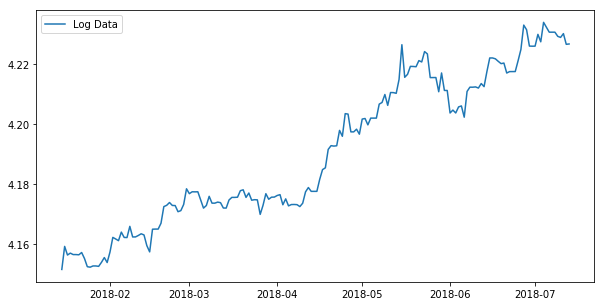

In [27]:
plt.rcParams["figure.figsize"] = fig_size
plt.plot(rate_data_log,label='Log Data')
plt.legend()
plt.show()

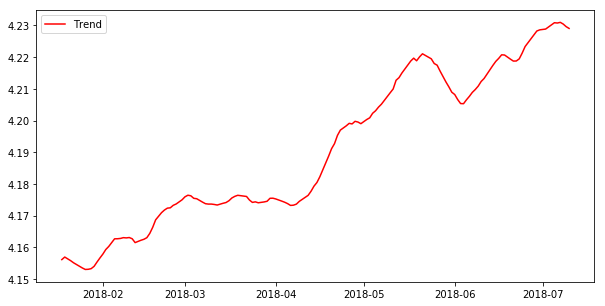

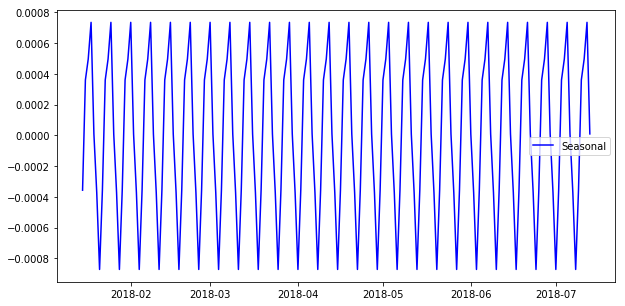

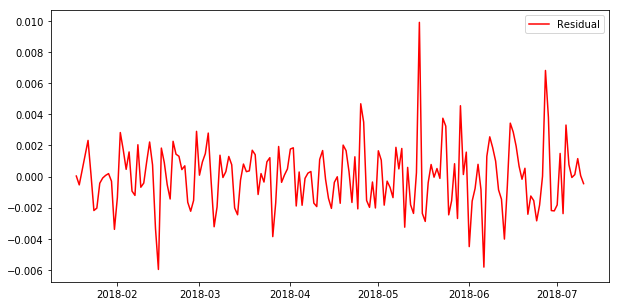

In [28]:
plt.plot(trend,color='red',label='Trend')
plt.legend()
plt.show()

plt.plot(seasonal,color='Blue',label='Seasonal')
plt.legend()
plt.show()

plt.plot(resid,color='red',label='Residual')
plt.legend()
plt.show()

In [29]:
resid.dropna(inplace=True)

df_test_resid = adfuller(resid, autolag='AIC')
result_resid = pd.Series(df_test_resid[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test_resid[4].items():
    result_resid['Critical Value (%s)'%key] = value
print (result_resid)

Test Statistic                -9.190151e+00
p-value                        2.134124e-15
#Lags Used                     4.000000e+00
Number of Observations Used    1.690000e+02
Critical Value (1%)           -3.469648e+00
Critical Value (5%)           -2.878799e+00
Critical Value (10%)          -2.575971e+00
dtype: float64


In [30]:
compare=pd.DataFrame({'Test Statistic':[result_rmean_diff.iloc[0],result_log.iloc[0],result_ewma.iloc[0],result_logdiff.iloc[0],result_resid.iloc[0]],
                      'p-value':[result_rmean_diff.iloc[1],result_log.iloc[1],result_ewma.iloc[1],result_logdiff.iloc[1],result_resid.iloc[1]]})
Methods=['Data Rolling mean','Log Data Rolling Mean','Log EWMA','First Order Differencing','Seasonal Decomposition']
compare['Methods']=Methods
compare=compare.set_index('Methods')
compare

,Test Statistic,p-value
Methods,,
Data Rolling mean,-4.691894,8.715344e-05
Log Data Rolling Mean,-4.680477,9.155380e-05
Log EWMA,-2.943951,4.047065e-02
First Order Differencing,-15.998319,6.553967e-29
Seasonal Decomposition,-9.190151,2.134124e-15


Evidently, first order differencing gives the best smoothing to the data. It is very commonly used for making time series stationary because it seldom fails. However, we explored a few other smoothing techniques only to be sure.
Another advantage of first order differencing is that 'statsmodels.arima_models' has accounted for first order differencing.

### Determine time lags

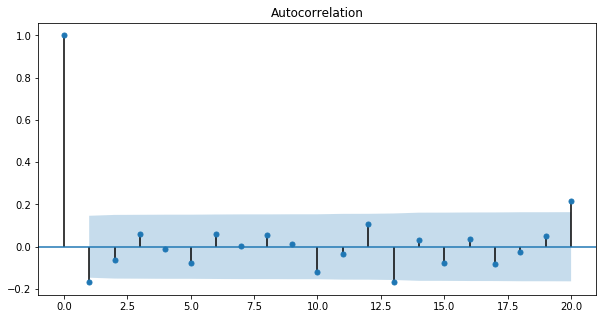

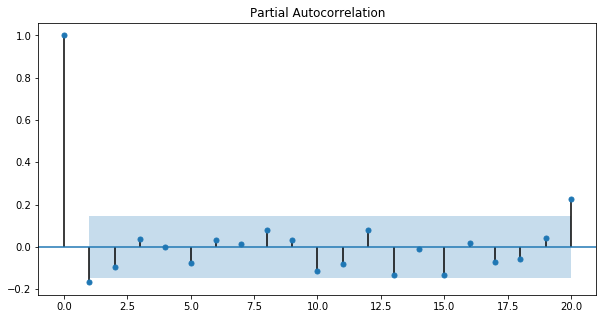

In [31]:
plot_acf(rate_log_diff,lags=20)
plt.show()

plot_pacf(rate_log_diff,lags=20)
plt.show()

## Forecast

In [32]:
# Error metric: Mean Squared error

def MSE(true_data,predictions):
    '''
    Input: 1. (list) True data
            2. (list) Predictions
            
    Returns: (float) Mean squared error
    '''
    
    if (len(true_data) == len(predictions)):
        mse = 0
        for i,element in enumerate(true_data):
            mse += (true_data[i]-predictions[i])**2
        return mse/len(true_data)
    
    else:
        raise Exception('Sizes of lists should match!')

### 1 day ahead forecast

In [33]:
data1 = rate_data_log.values
train = list(data1[0:125])
test = list(data1[125:])
otest = list(rate_data_log.values[125:0])

train_list = [x for x in train]
predictions = []

for t in range(len(test)):
    model = ARIMA(np.array(train),order=(1,1,0))
    fit = model.fit()
    forecast = float(fit.forecast()[0])
    predictions.append(forecast)
    train.append(float(test[t]))

C:\Users\kdabhadk\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\kdabhadk\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\kdabhadk\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [34]:
model = ARIMA(np.array(train),order=(1,1,0))
fit = model.fit()
full_predictions=list(fit.forecast(34)[0])

Mean squared error: 0.051078


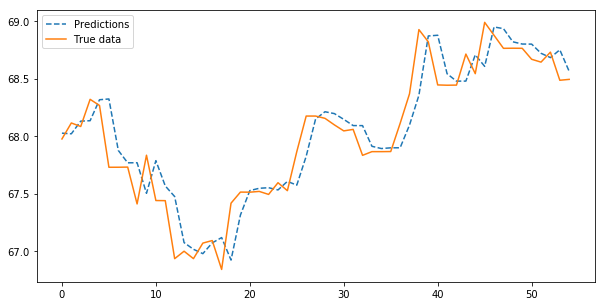

In [35]:
plt.plot(np.exp(predictions),'--',label='Predictions')
plt.plot(np.exp(test),label='True data')
#plt.plot(np.exp(full_predictions),label='Full prediction')
plt.legend()
plt.plot()

print ('Mean squared error: {0:3f}'.format(MSE(np.exp(test),np.exp(predictions))))

In [36]:
## Value of currency tomorrow will be:

#Tomorrow's value
data1 = rate_data_log.values
train = list(data1)

train_list = [x for x in train]
predictions = []

model = ARIMA(np.array(train),order=(1,1,0))
fit = model.fit()
forecast = float(fit.forecast()[0])

tomorrow_value = np.exp(forecast)

# Today's value

rate_data_log = rate_data_log[:-1]
data1 = rate_data_log.values
train = list(data1)

train_list = [x for x in train]
predictions = []

model = ARIMA(np.array(train),order=(1,1,0))
fit = model.fit()
forecast = float(fit.forecast()[0])
today_value = np.exp(forecast)

In [37]:
rate_data.tail()

,Rate
Day,
2018-07-09,68.6697
2018-07-10,68.6450
2018-07-11,68.7319
2018-07-12,68.4871
2018-07-13,68.4949


In [52]:
print ("Today's actual value is {0:3f} and model predicted {1:3f}.".format(rate_data.values[-1][0],today_value))
print ("Model predicts value will be {0:3f} tomorrow.".format(tomorrow_value))

Today's actual value is 68.494900 and model predicted 68.563838.
Model predicts value will be 68.526886 tomorrow.
